### 对应到完整版本Alg.3

In [70]:
import numpy as np
from TDD.TDD import TDD, Ini_TDD,Clear_TDD,set_index_order,get_unique_table_num,set_root_of_unit,get_count,cont,renormalize,Slicing2,Slicing,get_index_order
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs,gen_cir
from TDD.TN import Index,Tensor,TensorNetwork
import time
import random
from qiskit import QuantumCircuit,qasm2
import cProfile
from IPython.display import display, HTML,Image
# from PIL import Image
from PIL import Image as PILImage
import networkx as nx
import copy
from qiskit.circuit.library.standard_gates import HGate,U1Gate,U3Gate
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import UnitaryGate
from Pre import *

to_test = False

In [71]:
def state_pre(tdd,anc_num=0):
    global S, node_qubit
    Q = [tdd.node]
    S=[]
    anc_num = tdd.node_number()-1
    n = tdd.node.key+1
    cir = Circuit(n+anc_num,[])
    anc_avi = n
    node_qubit = {}
    get_ref(tdd.node,[])

    the_map=tdd.map
    while the_map.level>-1:
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if the_map.x==1:
            # cir.x(q)
            cir.data.append(Gate('x',{},q))
        if the_map.rotate>0:
            # cir.p(np.pi/4*(8-the_map.rotate),q)
            cir.data.append(Gate('p',{},q,np.pi/4*(8-the_map.rotate)))
        # print(q)
        the_map=the_map.father
    # print(the_map)
    while len(Q)>0:
        u = Q.pop(0)
        S.append(u)
        if not u in node_qubit:
            node_qubit[u] = anc_avi
            anc_avi+=1
        # print('u',u.key)
        the_map = u.out_maps[1]
        while the_map.level>-1:
            q0 = node_qubit[u]
            q1 = u.key
            idx = the_map.level
            q = int(tdd.key_2_index[idx][1:])
            if not q0>q1>q:
                the_map=the_map.father
                continue
            if the_map.x==1:
                # cir.ccx(q0,q1,q) 
                cir.data.append(Gate('x',{q0:1,q1:1},q))
            if the_map.rotate>0:
                # cir.mcp(np.pi/4*(8-the_map.rotate),[q0,q1],q)
                cir.data.append(Gate('p',{q0:1,q1:1},q,np.pi/4*(8-the_map.rotate)))
            # print([q0,q1],q)
            the_map=the_map.father

        #进一步优化
        if u.successor[0]==u.successor[1]:
            u.successor[0].ref-=2
            if u.successor[0].ref==0 and u.successor[0].key>-1:
                Q.append(u.successor[0])
            if u.successor[0].key>-1:
                if not u.successor[0] in node_qubit:
                    node_qubit[u.successor[0]] = anc_avi
                    anc_avi+=1
                cir.data.append(Gate('x',{node_qubit[u]:1},node_qubit[u.successor[0]]))
            continue
                
        u.successor[0].ref-=1
        # print(u.successor[0].ref)
        if u.successor[0].ref==0 and u.successor[0].key>-1:
            Q.append(u.successor[0])
        if u.successor[0].key>-1:
            # cir.x(u.key)
            cir.data.append(Gate('x',{},u.key))
            if not u.successor[0] in node_qubit:
                node_qubit[u.successor[0]] = anc_avi
                anc_avi+=1
            # cir.ccx(u.key,node_qubit[u],node_qubit[u.successor[0]])
            cir.data.append(Gate('x',{u.key:1,node_qubit[u]:1},node_qubit[u.successor[0]]))
            # cir.x(u.key)
            cir.data.append(Gate('x',{},u.key))
            
        u.successor[1].ref-=1
        if u.successor[1].ref==0 and u.successor[1].key>-1:
            Q.append(u.successor[1])
        if u.successor[1].key>-1:
            if not u.successor[1] in node_qubit:
                node_qubit[u.successor[1]] = anc_avi
                anc_avi+=1
            # cir.ccx(u.key,node_qubit[u],node_qubit[u.successor[1]])
            cir.data.append(Gate('x',{u.key:1,node_qubit[u]:1},node_qubit[u.successor[1]]))


    for k in range(len(S)-1,-1,-1):
        u=S[k]
        # print(u.key)


        if u.successor[0]==u.successor[1] and u.successor[0].key>-1:
            cir.data.append(Gate('x',{node_qubit[u]:1},node_qubit[u.successor[0]]))
        else:
            if u.successor[0].key>-1:
                # cir.x(u.key)
                cir.data.append(Gate('x',{},u.key))
                # cir.ccx(u.key,node_qubit[u],node_qubit[u.successor[0]])
                cir.data.append(Gate('x',{u.key:1,node_qubit[u]:1},node_qubit[u.successor[0]]))
                # cir.x(u.key)
                cir.data.append(Gate('x',{},u.key))
            
            if u.successor[1].key>-1:
                # cir.ccx(u.key,node_qubit[u],node_qubit[u.successor[1]])
                cir.data.append(Gate('x',{u.key:1,node_qubit[u]:1},node_qubit[u.successor[1]]))


        w0 = u.out_weight[0]*u.successor[0].hold_prob
        w1 = u.out_weight[1]*u.successor[1].hold_prob
        # a = u.out_weight[1]
        a=w1/w0
        if abs(a)>1e-10:
            M = 1/np.sqrt(1+abs(a)**2)*np.array([[1,np.conj(a)],[-a,1]])
            # u3 = UnitaryGate(M)
            # cu3 = u3.control(1)
            # cir.append(cu3,[node_qubit[u],u.key])
            cir.data.append(Gate('u',{node_qubit[u]:1},u.key,M))
        u.hold_prob = w0*np.sqrt(1+abs(a)**2)

    return cir

def extend_tdd(tdd):
    var=[]
    q_n = tdd.node.key+tdd.node_number()
    for k1 in range(q_n):
        if not 'x'+str(k1) in var:
            var.append('x'+str(k1))
        if not 'a'+str(k1) in var:
            var.append('a'+str(k1))        
        for k in range(30*q_n):
            s ='x'+str(k1)+'_'+str(k)
            if not s in var:
                var.append(s)
            s ='y'+str(k1)+'_'+str(k)
            if not s in var:
                var.append(s)               
        if not 'y'+str(k1) in var:
            var.append('y'+str(k1))
        if not 'b'+str(k1) in var:
            var.append('b'+str(k1))        
    var.reverse()
    set_index_order(var)

    U0=np.array([1,0])
    U1=np.array([0,1])
    tdd_new = tdd.self_copy()
    for q in range(tdd.node.key+1,q_n,1):
        if q==tdd.node.key+1:
            ts=Tensor(U1,[Index('y'+str(q))],'out',[k])
        else:
            ts=Tensor(U0,[Index('y'+str(q))],'out',[k])
        tdd_new=cont(tdd_new,ts.tdd())
    return tdd_new

def is_zero_state(node):
    if node.key==0:
        return True
    if node.successor[0]!=node.successor[1]:
        return False
    if node.out_weight[0]!=1 or node.out_weight[1]!=0:
        return False
    if node.out_maps[1].level!=-1:
        return False
    return is_zero_state(node.successor[0])
    
def is_successful(tdd,n):
    if tdd.map.level!=n:
        return False
    if tdd.map.x!=1:
        return False
    if tdd.map.rotate!=0:
        return False
    if tdd.map.father.level!=-1:
        return False
    return is_zero_state(tdd.node)

{-1: -1, 0: 'y0', 1: 'y1', 2: 'y2', 3: 'y3'}


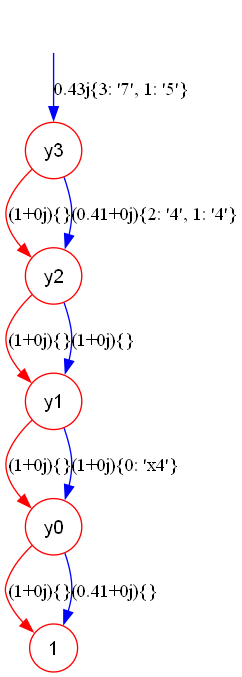

In [72]:
n=4
m=100

cir=gen_cir('Random_Clifford_T',n,m)
tdd=simulate(cir,True,n)
print(tdd.key_2_index)
tdd=renormalize(tdd)
tdd.show()

1
2
3
4
True


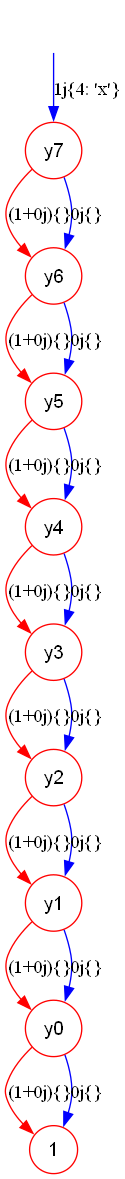

In [73]:
cir_head = QuantumCircuit(n+tdd.node_number()-1)
# tdd222=tdd.self_copy()
cir_end = state_pre(tdd.self_copy())
# print(tdd222==tdd)
print('1')
tdd_new = extend_tdd(tdd)
print('2')
cir_end = cir_end.to_qis_cir()
tdd_new2 = update_tdd(tdd_new,cir_head,cir_end)
print('3')
tdd_new2 = renormalize(tdd_new2)
print('4')
print(is_successful(tdd_new2,n))
tdd_new2.show()